# Character Recognition Module

This notebook is for utilizing easyocr on a section of an image in order to get the text from that image. Please only run this notebook as the other is primarily used for model training.

In [ ]:
import os
import glob
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import shutil
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import io
import imageio
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage



: 

In [2]:
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/"ERD Clustering"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/CS Courses/ERD Clustering


In [3]:
# Install tensorflow object detection module.
# clone the tensorflow models on the colab cloud vm
#!git clone --q https://github.com/tensorflow/models.git
# navigate to /models/research folder to compile protos

# ONLY RUN THIS CELL ON YOUR FIRST RUN
%cd models/research

!protoc object_detection/protos/*.proto --python_out=.

!cp object_detection/packages/tf2/setup.py .
!python -m pip install .


/content/gdrive/MyDrive/CS Courses/ERD Clustering/models/research
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/gdrive/MyDrive/CS Courses/ERD Clustering/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 14.5 MB 9.8 MB/s 
     |████████████████████████████████| 352 kB 56.2 MB/s 
     |████████████████████████████████| 2.3 MB 37.6 MB/s 
     |████████████████████████████████| 26.9 MB 1.3 MB/s 
     |████████████████████████████████| 67 kB 5.5 MB/s 
     |████████████████████████████████| 116 kB 59.4 MB/s 
     |██████████

In [9]:
# run the first time, ignore the second time

%cd /content/gdrive/MyDrive/"ERD Clustering"/models/research
!python object_detection/builders/model_builder_tf2_test.py

/content/gdrive/MyDrive/CS Courses/ERD Clustering/models/research
2022-12-01 14:36:37.497545: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-01 14:36:37.497775: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-01 14:36:37.497804: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
/usr/local/lib/python3.8/dist-packages/tensor

In [3]:
%cd /content/gdrive/MyDrive/"ERD Clustering"/customTF2/

import tensorflow
print(tensorflow.__version__)
import keras
print(keras.__version__)
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import config_util
from object_detection.utils import colab_utils
from object_detection.builders import model_builder


/content/gdrive/MyDrive/CS Courses/ERD Clustering/customTF2
2.11.0
2.11.0


/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [11]:
# Run this cell the first time through, ignore this the second time you run this notebook
!pip uninstall tensorflow
!pip uninstall keras
!pip install tensorflow==2.11
!pip install keras==2.11

Found existing installation: tensorflow 2.11.0
Uninstalling tensorflow-2.11.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.8/dist-packages/tensorflow-2.11.0.dist-info/*
    /usr/local/lib/python3.8/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.11.0
Found existing installation: keras 2.11.0
Uninstalling keras-2.11.0:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/keras-2.11.0.dist-info/*
    /usr/local/lib/python3.8/dist-packages/keras/*
Proceed (y/n)? y
  Successfully uninstalled keras-2.11.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow-2.11.0-cp38-cp38-manylinux_2_17_x86_64.manylinu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.
  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.
  Args:
    path: a file path.
  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  print(image.size)
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(20, 20),
                    image_name=None):
  """Wrapper function to visualize detections.
  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

In [5]:
# Get detection model
model_dir = '/content/gdrive/MyDrive/ERD Clustering/customTF2/training/MyMobileNet'
configs = config_util.get_configs_from_pipeline_file('/content/gdrive/MyDrive/ERD Clustering/customTF2/models/ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8/pipeline.config')
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# restore checkpoint

ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore('/content/gdrive/MyDrive/ERD Clustering/customTF2/training/MyMobileNet/ckpt-6.index'.replace('.index', ''))

def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

In [6]:
# map labels for inference decoding
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)
print(categories)

[{'id': 1, 'name': 'entity'}, {'id': 2, 'name': 'weak_entity'}, {'id': 3, 'name': 'rel'}, {'id': 4, 'name': 'ident_rel'}, {'id': 5, 'name': 'rel_attr'}, {'id': 6, 'name': 'many'}, {'id': 7, 'name': 'one'}]


In [7]:
# helper functions for dealing with sections of images

def normalized_coordinates(image, boxes):
  adj_boxes = []
  im_width, im_height = image.size
  for box in boxes: 
    adj_boxes.append([box[0] * im_height, box[1] * im_width, box[2] * im_height, box[3] * im_width]) # ymin, xmin, ymax, xmax
  return adj_boxes



/content/gdrive/MyDrive/CS Courses/ERD Clustering/customTF2
['/content/gdrive/MyDrive/ERD Clustering/customTF2/data/test_labels_jpg/068.jpg', '/content/gdrive/MyDrive/ERD Clustering/customTF2/data/test_labels_jpg/111.jpg', '/content/gdrive/MyDrive/ERD Clustering/customTF2/data/test_labels_jpg/020.jpg', '/content/gdrive/MyDrive/ERD Clustering/customTF2/data/test_labels_jpg/043.jpg', '/content/gdrive/MyDrive/ERD Clustering/customTF2/data/test_labels_jpg/061.jpg', '/content/gdrive/MyDrive/ERD Clustering/customTF2/data/test_labels_jpg/013.jpg', '/content/gdrive/MyDrive/ERD Clustering/customTF2/data/test_labels_jpg/116.jpg', '/content/gdrive/MyDrive/ERD Clustering/customTF2/data/test_labels_jpg/134.jpg', '/content/gdrive/MyDrive/ERD Clustering/customTF2/data/test_labels_jpg/107.jpg', '/content/gdrive/MyDrive/ERD Clustering/customTF2/data/test_labels_jpg/108.jpg', '/content/gdrive/MyDrive/ERD Clustering/customTF2/data/test_labels_jpg/045.jpg', '/content/gdrive/MyDrive/ERD Clustering/customTF

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


tf.Tensor([0 1 2 4 3], shape=(5,), dtype=int32)


<function matplotlib.pyplot.show(*args, **kw)>

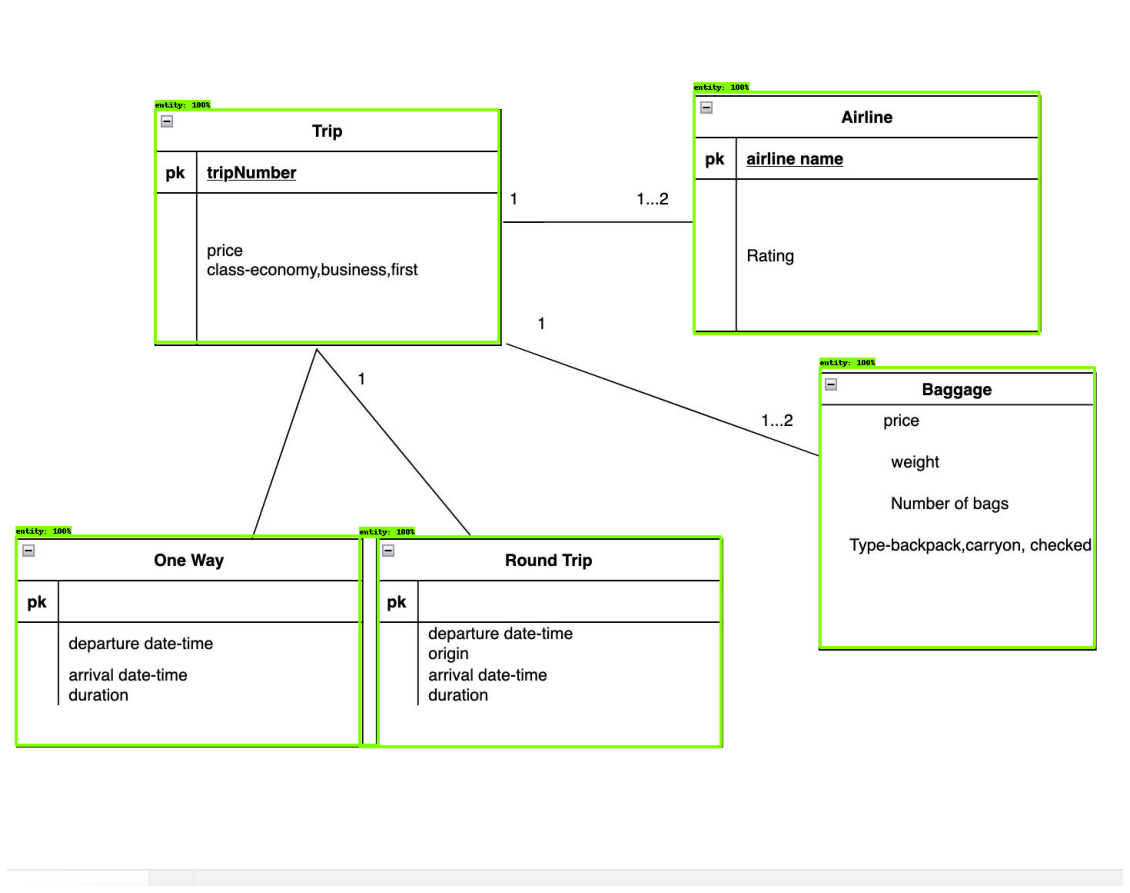

In [8]:
# Used to test that utilizing non max suppression algorithm worked on reducing bounding boxes

%cd /content/gdrive/MyDrive/"ERD Clustering"/customTF2/ 
import random

TEST_IMAGE_PATHS = glob.glob('/content/gdrive/MyDrive/ERD Clustering/customTF2/data/test_labels_jpg/*.jpg')
print(TEST_IMAGE_PATHS)
image_path = random.choice(TEST_IMAGE_PATHS)
image_np = load_image_into_numpy_array(image_path)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
print(detect_fn)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()


idx, soft_scores = tf.image.non_max_suppression_with_scores(detections['detection_boxes'][0], detections['detection_scores'][0], max_output_size=len(detections['detection_boxes'][0]), iou_threshold=.99, score_threshold=.25, soft_nms_sigma=.2)
print(idx)
boxes = detections['detection_boxes'][0].numpy()
classes = (detections['detection_classes'][0].numpy() + label_id_offset).astype(int)
scores = detections['detection_scores'][0].numpy()

selected_boxes = boxes[idx.numpy()]
selected_classes = classes[idx.numpy()]
#print(selected_boxes)
#selected_scores = scores[idx.numpy()]
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      selected_boxes,
      classes,
      soft_scores.numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.25,
      agnostic_mode=False,
)
%matplotlib inline
plt.figure(figsize=(20,20))
plt.imshow(image_np_with_detections)
plt.axis("off")
plt.show

In [9]:
!pip install easyocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 6.3 MB/s 
     |████████████████████████████████| 145 kB 53.1 MB/s 
     |████████████████████████████████| 619 kB 52.1 MB/s 


In [10]:
#import pytesseract
import easyocr
import cv2
from PIL import Image, ImageGrab
# categories: [{'id': 1, 'name': 'entity'}, {'id': 2, 'name': 'weak_entity'}, {'id': 3, 'name': 'rel'}, {'id': 4, 'name': 'ident_rel'}, {'id': 5, 'name': 'rel_attr'}, {'id': 6, 'name': 'many'}, {'id': 7, 'name': 'one'}]
img = Image.open(image_path)
boxes = detections['detection_boxes'][0].numpy()
classes = (detections['detection_classes'][0].numpy() + label_id_offset).astype(int)
# scores = detections['detection_scores'][0].numpy()
selected_boxes = normalized_coordinates(img, boxes[idx.numpy()]) # ymin, xmin, ymax, xmax
# print(soft_scores)
# print(selected_boxes)
# print(selected_classes)
i = 0
results = []
for box, label in zip(selected_boxes, selected_classes):
  print(f"box {i}: {box}")
  curr_label = ""
  for category in categories:
      if category['id'] == label:
        curr_label = category['name']
        break
  #print(curr_label)
  curr_result = [curr_label]

  temp_img = img
  crop_rectangle = (box[1], box[0], box[3], box[2]) # left, upper, right, lower
  cropped_im = np.array(temp_img.crop(crop_rectangle))


  reader = easyocr.Reader(['en'], gpu=True)
  result = reader.readtext(cropped_im)
  #print(result)
  for r in result:
    curr_result.append(r[1])
  results.append(curr_result)
  plt.imshow(cropped_im)
  filename = '/content/gdrive/MyDrive/ERD Clustering/customTF2/testOCR/box_' + str(i)
  plt.savefig(filename)
  plt.close()
  i += 1
print(results)

box 0: [690.2413139343262, 458.36921668052673, 962.8883867263794, 929.7794358730316]
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

box 1: [135.00444507598877, 192.76166117191315, 436.9430503845215, 640.525710940361]


box 2: [112.49580013751984, 893.085599899292, 425.6378684043884, 1343.1973814964294]


box 3: [470.15056920051575, 1057.2764976024628, 833.1555337905884, 1415.374362230301]


box 4: [689.1217398643494, 11.111568868160248, 960.8983283042908, 483.59130120277405]
[['entity', 'Round Trip', 'pk', 'departure date-time', 'origin', 'arrival date-time', 'duration'], ['entity', 'Trip', 'pk', 'tripNumber', 'class-economy,business,first', 'price'], ['entity', 'Airline', 'pk', 'airline name', 'Rating'], ['entity', 'Baggage', 'weight', 'Number of bags', 'Type-backpack,carryon, checked', 'price'], ['entity', 'One', 'pk', 'departure date-time', 'arrival date-time', 'duration', 'Way']]


# Clustering
Below is the code for storing the data in json file